# Import packages

In [1]:
from array import array
import csv
import itertools
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import astroML.density_estimation as aml
import astroML.plotting as amlplot
import iminuit
import pandas as pd
import root_pandas as rpd
import ROOT

mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 16}) 
mpl.rcParams.update({'ytick.labelsize': 16}) 


Welcome to JupyROOT 6.09/01


# Get data from Ntuples
## Get dataframes from TTrees

In [2]:
def getData(inputFiles):
    maxEvents = 500000
    
    columns = []
    columns.append('ncluster')
    columns.append('ntrack')

    columns.append('run_number')
    #columns.append('multiplicity_v0')
    columns.append('primary_vertex_ncontributor')
    columns.append('npileup_vertex_spd')
   # columns.append('is_pileup_from_spd_3_08')
    #columns.append('pileup_vertex_spd_min_z_distance')
    columns.append('cluster_pt')
    columns.append('cluster_eta')
    columns.append('cluster_phi')
    columns.append('cluster_e_cross')
    columns.append('cluster_e')
    columns.append('cluster_tof')
    columns.append('cluster_ncell')
    columns.append('cluster_iso_tpc_04')
    columns.append('cluster_iso_tpc_04_ue')
    columns.append('cluster_iso_its_04')
    columns.append('cluster_iso_its_04_ue')
    columns.append('cluster_iso_its_02')

    columns.append('cluster_frixione_tpc_04_02')
    columns.append('cluster_frixione_its_04_02')
    columns.append('cluster_nlocal_maxima')
    columns.append('cluster_b5x5_lin')
    columns.append('cluster_b5x5')
    columns.append('cluster_NN1')
    columns.append('cluster_NN2')
    columns.append('cluster_Lambda')
    columns.append('cluster_minMass')
    columns.append('cluster_SuperModule')
    
    start = time.time()
    dataframe = rpd.read_root(inputFiles, columns=columns, flatten=True, stop=maxEvents)
    end = time.time()
    print 'Processed', ','.join(inputFiles), 'in', end-start, 'seconds'
        
    return dataframe

## Define cuts and generate cut flow plots

In [3]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe

def applyCuts(fullDataframe): 
    
    #FIGURE TO PLOT CUTFLOW:
    fig = plt.figure(figsize=(16,16))
    mpl.rcParams['legend.fontsize'] = 8


    #CREATE ADDITIONAL VARIABLES
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e', inplace=True)
    fullDataframe.eval('cluster_iso_its_04_raw = cluster_iso_its_04+cluster_iso_its_04_ue', inplace=True)
    fullDataframe.eval('cluster_iso_tpc_04_raw = cluster_iso_tpc_04+cluster_iso_tpc_04_ue', inplace=True)
    dataframe = fullDataframe
    
 
    plt.subplot(441)
    #plt.hist(dataframe['is_pileup_from_spd_3_08'], bins=2,color='orange',normed=True)
    #plt.axvline(x=0.5, color='r')
    #plt.xlabel('is_pileup_from_spd_03_08')
    #dataframe = applyCut(dataframe, 'is_pileup_from_spd_3_08<1', 'Is not pile up SPD 03/08:')

    plt.subplot(442)
    plt.hist(dataframe['cluster_ecross_over_e'],bins=100,color='orange', label='all',normed=True)
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e>0.05', 'ecross/e > 0.05 :')
    plt.axvline(x=0.05,color='r')
    plt.xlabel('Ecross/E')
    plt.legend()
    
    plt.subplot(443)
    #SUPERMODULE Distribution and removal of supermodules
    plt.hist(dataframe['cluster_tof'], bins=100, color='orange',normed=True)
    plt.xlabel('cluster time [ns]')
    plt.yscale('log', nonposy='clip')
   
    #pt distribution and pt cut
    plt.subplot(444)
    plt.hist(dataframe['cluster_pt'],bins=80, range=(10.0,50.0),color='orange',normed=True)
    dataframe = applyCut(dataframe, 'cluster_pt>10.0', 'pt >10.0  GeV :')
    dataframe = applyCut(dataframe, 'cluster_pt<16.0', 'pt <16.0  GeV :')

    plt.axvline(x=10.0,color='r')
    plt.axvline(x=16.0,color='r')
    plt.xlabel('cluster pt [GeV]')
    plt.yscale('log', nonposy='clip')


    #Number of cells
    plt.subplot(445)
    plt.hist(dataframe['cluster_ncell'],range=(0,25), bins=25,color='orange',normed=True)
    dataframe = applyCut(dataframe, 'cluster_ncell>2', 'ncell > 2:')
    plt.xlabel('Number of cells in cluster')
    plt.axvline(x=2.0,color='r')
    #plt.axvline(x=16.0,color='r')
    #plt.hist(dataframe['cluster_ncell'],range=(0,25), bins=25,color='black',histtype='step')

    #DROP NA from NN1
    dataframe = applyCut(dataframe, 'cluster_NN1>0 and cluster_NN1<1.0', '0<NN1<1.0 :')
    dataframe = applyCut(dataframe, 'cluster_NN2>0 and cluster_NN2<1.0', '0<NN2<1.0 :')
    
    #NUMBER OF LOCAL MAXIMA CUT
    dataframe = applyCut(dataframe, 'cluster_nlocal_maxima<3', 'Local Maxima < 3 :')

    #PLOT ISOLATION DISTRIBUTIONS
    plt.subplot(446) 
    plt.hist(dataframe['cluster_frixione_its_04_02'], range=(-25,25), bins=100,label='Frixione_its_04_02',histtype='step')
    plt.hist(dataframe['cluster_iso_its_04'], range=(-25,25), bins=100,label='cone_its_04',histtype='step')
    plt.axvline(x=2.0, color='r')
    plt.axvline(x=5.0, color='g')
    plt.legend()
    #plt.yscale('log', nonposy='clip')

    
    #plt.subplot(336)
    #plt.hist(dataframe['cluster_frixione_its_04_02'], range=(-25,25), bins=100, cumulative=True, normed=True,histtype='step',label='Frixione_its_04_02')
    #plt.hist(dataframe['cluster_iso_its_04'], range=(-25,25), bins=100, cumulative=True, normed=True,histtype='step',label='cone_its_04')
    #plt.axvline(x=2.0, color='r')
    #plt.axvline(x=5.0, color='g')
    #plt.legend()
    
    plt.subplot(447)
    #PLOT ETA/Phi distributions
    plt.hist(dataframe['cluster_eta'], bins=100,color='orange',normed=True)
    plt.xlabel('cluster eta')
    dataframe = applyCut(dataframe, 'abs(cluster_eta)<0.6', '|eta| < 0.6 :')
    #plt.hist(dataframe['cluster_eta'], bins=100,histtype='step',color='black')
    plt.axvline(x=0.60,color='r')
    plt.axvline(x=-0.60,color='r')
    
    plt.subplot(448)
    plt.hist(dataframe['cluster_phi'], bins=100,normed=True)
    plt.xlabel('cluster_phi')
    plt.subplot(449)
    plt.hexbin(x=dataframe['cluster_eta'], y=dataframe['cluster_phi'], cmap='inferno')
    plt.xlabel('cluster eta')
    plt.ylabel('cluster phi')

    plt.subplot(4,4,10)
    plt.hist(dataframe['cluster_SuperModule'],bins=20,range=(0,20), color='orange', normed=True)
    plt.xlabel('cluster supermodule')
    
    isodata = applyCut(dataframe, 'cluster_frixione_its_04_02<2', 'cluster_frixione_its_04_02 < 2 GeV:')
    plt.subplot(4,4,11)
    for ism in range(10):
        plt.hist(isodata[isodata.cluster_SuperModule==ism]['cluster_NN1'], bins=50,range=(0,1.0), normed=True, 
                 label='SM=%i GeV'%(ism), histtype='step')
    plt.legend(title='Iso<2 GeV', ncol=3)
    plt.show()
    fig.savefig('Cutflow_dataset.png')

    
    fig = plt.figure(figsize=(12,12))
    for ism in range(9):
        plt.subplot(3,3,ism+1)
        plt.hist(isodata[isodata.cluster_SuperModule==ism]['cluster_NN1'], bins=50,range=(0,1.0), normed=True, 
                 label='SM=%i GeV'%(ism), histtype='step')
        plt.legend(loc='best')
        plt.ylim([0.0,8.0])

    fig.savefig('SupermoduleResponseIsolated.png')
    
    
    plt.show()
    
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=3', 'SM!=3')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=7', 'SM!=3')
    return dataframe

# Build templates from dataframes

In [28]:
def getIsoSplitHists(data, bins, isoCut, nonisoCuts, var, isovar, varRange):
    hfull, binEdges = np.histogram(data[var], bins, range=varRange)
    hiso, _ = np.histogram(data.query('%s<%f'%(isovar,isoCut))[var], binEdges, range=varRange)
    hnoniso, _ = np.histogram(data.query('%s>%f and %s<%f'%(isovar,nonisoCuts[0],isovar, nonisoCuts[1]))[var], binEdges, range=varRange)

    return hfull, hiso, hnoniso, binEdges

#it was 10-15 GeV
def getTemplates(dataHists, mcHists, bins, isocut=2, nonisocuts=(5,10), var='cluster_NN1', isovar='cluster_frixione_its_04_02', varRange=(0.0, 1.0)):
    _, dataiso, datanoniso, binEdges = getIsoSplitHists(dataHists, bins, isocut, nonisocuts, var, isovar, varRange)
    #signalmc, _ = np.histogram(mcHists[var], binEdges, range=varRange)
    _, signalmc, _bkg, binEdges = getIsoSplitHists(mcHists, bins,isocut,nonisocuts,var,isovar,varRange)
     
    dataisoerr = np.sqrt(dataiso)
    datanonisoerr = np.sqrt(datanoniso)
    signalmcerr = np.sqrt(signalmc)
    
    return dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges

# Define template fit and purity

In [49]:
def haveSameLength(*args):
    n = len(args[0])
    return all(len(l) == n for l in args)

def normalize(x):
    return np.array(x, dtype='f')/np.sum(x)

def getBinRange(binEdges, valuemin, valuemax):
    binmin = min([i for i, edge in enumerate(binEdges) if edge >= valuemin])
    binmax = max([i for i, edge in enumerate(binEdges) if edge <= valuemax])
    return binmin, binmax
    
def getPurity(signal, bkg, binEdges, frac, purityMin, purityMax, returnRange=False):
    # signal and bkg should be normalized to 1
    pmin, pmax = getBinRange(binEdges, purityMin, purityMax)
    purity = np.sum(frac*signal[pmin:pmax])/(np.sum([(1-frac)*bkg[pmin:pmax], frac*signal[pmin:pmax]]))
    
    if returnRange:
        return purity, pmin, pmax
    else:
        return purity

class TemplateFit:
    def __init__(self, data, dataerr, signal, signalerr, bkg, bkgerr, binEdges, fitRange=None, verbosity=1, fixN=True, fixf =False):       
        if not haveSameLength(data, dataerr, signal, signalerr, bkg, bkgerr, binEdges[1:]):
            raise ValueError('Inputs do not have the same length (binEdges should have 1 more than the rest)')
        
        self.data = np.array(data, dtype='f')
        self.dataerr = np.array(dataerr, dtype='f')
        self.inputSignal = np.array(signal, dtype='f')
        self.inputSignalerr = np.array(signalerr, dtype='f')
        self.inputBkg = np.array(bkg, dtype='f')
        self.inputBkgerr = np.array(bkgerr, dtype='f')
        self.binEdges = binEdges
        self.fixN = fixN
        self.fixf = fixf
        if fitRange:
            self.fitRange = getBinRange(binEdges, *fitRange)
        else:
            self.fitRange = (0, None)
        
        self.signal = self.inputSignal/np.sum(self.inputSignal)
        self.signalerr = self.inputSignalerr/np.sum(self.inputSignal)
        self.bkg = self.inputBkg/np.sum(self.inputBkg)
        self.bkgerr = self.inputBkgerr/np.sum(self.inputBkg)
        self.binCenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        self.binWidths = np.array([hedge-ledge for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
               
        self.signalColor = '#3B7EA1'
        self.bkgColor = '#FDB515'
        self.figureSize = (10, 8)
        
        self.verbosity = verbosity
               
        self.doFit()
        
    def doFit(self):
        def Chi2(N, f):
            model = N*(f*self.signal + (1-f)*self.bkg)
            totalerror = np.sqrt(np.square(self.dataerr) + np.square(N*(1-f)*self.bkgerr))
            return np.sum(np.power(np.divide(self.data-model, totalerror,
                                             out=np.zeros_like(totalerror), where=totalerror!=0), 2.0)[slice(*self.fitRange)])

        mt = iminuit.Minuit(Chi2, N=np.sum(self.data), fix_N=self.fixN,  f=0.0, fix_f = self.fixf, error_N=1, error_f=0.01,
                            errordef=1, print_level=self.verbosity)
        mt.migrad()
        #mt.minos()
        self.migrad = mt
        self.fitN = mt.values['N']
        self.fitNerr = mt.errors['N']
        self.fitf = mt.values['f']
        self.fitferr = mt.errors['f']
        
        self.fitSignal = self.fitN*self.fitf*self.signal
        self.fitSignalerr = self.fitN*self.fitf*self.signalerr
        self.fitBkg = self.fitN*(1-self.fitf)*self.bkg
        self.fitBkgerr = self.fitN*(1-self.fitf)*self.bkgerr
        
        fitTotal = self.fitSignal + self.fitBkg
        
        totalerror = np.sqrt(np.square(self.dataerr) + np.square(self.fitN*(1-self.fitf)*self.bkgerr))
      
        
        self.residuals = np.divide(self.data- fitTotal , totalerror,
                                   out=np.zeros_like(totalerror), where=totalerror!=0)
        self.chi2 = Chi2(self.fitN, self.fitf)
        self.dof = len(self.data[slice(*self.fitRange)])-3

    def getPurity(self, purityMin, purityMax):
        purity, pmin, pmax = getPurity(self.signal, self.bkg, self.binEdges, self.fitf, purityMin, purityMax, True)
        puritylow = getPurity(self.signal, self.bkg, self.binEdges, self.fitf-self.fitferr, purityMin, purityMax)
        purityhigh = getPurity(self.signal, self.bkg, self.binEdges, self.fitf+self.fitferr, purityMin, purityMax)
        if self.verbosity == 1:
            print 'Purity = %2.5f, +%2.5f, -%2.5f'%(purity, purityhigh-purity, purity-puritylow)
        return purity,  pmin, pmax
        
    def plotFit(self, xlabel, title,  showPurity=False, purityMin=0.0, purityMax=1.0, newFigure=True, ylimit=-1.0, figureFilename='', normalize=True):
        if newFigure:
            fig = plt.figure(figsize=self.figureSize)
        
        if normalize:
            norm = self.fitN*(self.binCenters[1]-self.binCenters[0])
        else:
            norm = 1
            
            
        fig.add_axes((0.1,0.3,0.9,0.6))
        dataplot = plt.errorbar(self.binCenters, self.data/norm, yerr=self.dataerr/norm,label='Data, Iso',fmt='ko',alpha=.45)
       
        bkgplot = plt.bar(self.binCenters, self.fitBkg/norm, yerr=self.fitBkgerr/norm, width=self.binWidths,
                align='center', label='Bkg (data non-Iso)', capsize=0,
                color=self.bkgColor, ec=self.bkgColor, ecolor=self.bkgColor)
        signalplot = plt.bar(self.binCenters, self.fitSignal/norm, yerr=self.fitSignalerr/norm, bottom=self.fitBkg/norm, width=self.binWidths,
                align='center', label='Signal (MC)', capsize=0,
                color=self.signalColor, ec=self.signalColor, ecolor=self.signalColor)   
    
        purity, pmin, pmax = self.getPurity(purityMin, purityMax)
        chi2_insignalregion = sum(np.square(self.residuals)[pmin:pmax])/len(np.square(self.residuals)[pmin:pmax]-2)
        chi2text, = plt.plot([], [], ' ', label='Chi2/dof=%2.1f\nf=(%2.1f$\pm$%2.1f)%% \nN=%5.0f'%(self.chi2/self.dof,
                                                                                                    100.0*self.fitf,100.0*self.fitferr,  self.fitN))
 
        #If bkg only fit, then show the range used in fit
        if self.fixf:
            ax = plt.gca()
            #ax.axvspan(self.fitRange[0], self.fitRange[1], color='red', alpha=0.4)
            
            ax.axvspan(self.binCenters[self.fitRange[0]]-self.binWidths[self.fitRange[0]]/2.0, 
                       self.binCenters[self.fitRange[1]]-self.binWidths[self.fitRange[1]]/2.0,color='red', alpha=0.4,label='fit region')
            
            purity, pmin, pmax = self.getPurity(puritymin, puritymax)
            total = np.sum(self.data[pmin:pmax])
            bkg_estimate = self.fitN*np.sum(self.bkg[pmin:pmax]) 
            signal_estimate = (total-(1-self.fitf)*bkg_estimate)
            purity = signal_estimate/total
            plt.suptitle('%s; Purity=%2.1f%%; Nsignal=%5.0f'%(title, 100.0*purity, signal_estimate))
#           print 'purity, BKG only method = %2.2f'% (100.0*(total-(1-tf.fitf)*bkgestimate)/total)
            ax.axvspan(self.binCenters[pmin]-self.binWidths[pmin]/2.0,self.binCenters[pmax]+self.binWidths[pmax]/2.0,
                       color='black', alpha=0.2)


        elif showPurity:
            purity, pmin, pmax = self.getPurity(purityMin, purityMax)
            puritylow = getPurity(self.signal, self.bkg, self.binEdges, self.fitf-self.fitferr, purityMin, purityMax)
            purityhigh = getPurity(self.signal, self.bkg, self.binEdges, self.fitf+self.fitferr, purityMin, purityMax)
            
            nsignal = purity*sum(self.data[pmin:pmax])
            nsignal_all = purity*sum(self.data)
            ax = plt.gca()
            ax.axvspan(self.binCenters[pmin]-self.binWidths[pmin]/2.0,self.binCenters[pmax]-self.binWidths[pmax]/2.0,
                       color='black', alpha=0.2)
            plt.title('%s; Purity=%2.1f$\pm$%2.1f%%; Nsignal=%5.0f'%(title, 100.0*purity, 100.0*(purityhigh-purity), nsignal))
        else:
            plt.suptitle(title)

        plt.legend(handles=[dataplot, signalplot, bkgplot, chi2text], numpoints=1, loc='best', fontsize=12)
        plt.xlabel(xlabel)
        plt.ylabel('Entries')
        if ylimit>0:
            plt.ylim([0.0,ylimit])
        
      
         
        #if not bkg only fit, plot residuals behind
        #if not self.fixf:
        if True:
            fig.add_axes((0.1,0.1,0.9,0.2)) 
            plt.plot(self.binCenters, self.residuals, 'o')
            plt.xlabel(xlabel)
            plt.ylabel('(Data-Fit)/Erorr')
            plt.ylim([-7.9,7.9])
            
            average = np.average(self.residuals)
            std    = np.std(self.residuals)
            if not self.fixf:
                plt.axhline(y=average,color='r',label='Average')
            else: 
                plt.axhline(y=0,color='blue',label='0.0')
            #plt.axhline(y=average+std,color='r',linestyle='--', label='+/- RMS')
            plt.legend(loc='best')
            #plt.axhline(y=average-std,color='r',linestyle='--')
        
            #plt.errorbar(self.binCenters, self.data/norm, yerr=self.dataerr/norm,label='Data, Iso',fmt='ko',alpha=.45)

        if newFigure:
            plt.show()
            
        if figureFilename:
            #fig.tight_layout()
            fig.savefig(figureFilename)
            
    def plotResiduals(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(10,4))
        plt.plot(self.binCenters, self.residuals, 'o')
        plt.xlabel(xlabel)
        plt.ylabel('(Data-Fit)/Erorr')
        plt.ylim([-6.5,6.5])
        average = np.average(self.residuals)
        std    = np.std(self.residuals)
        plt.axhline(y=average,color='r',label='Average')
        #plt.axhline(y=average+std,color='r',linestyle='--', label='+/- RMS')
        plt.legend(loc='best')
        #plt.axhline(y=average-std,color='r',linestyle='--')

        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()
        
    
    def plotProfile(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=self.figureSize)
        self.migrad.draw_mnprofile('f', bound=3,subtract_min=True,text=False);
        plt.show()
        if figureFilename:
            fig.savefig(figureFilename)
        plt.show()

        
    def plotTemplates(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(self.figureSize[0], self.figureSize[1]/2.0))
        plt.bar(self.binCenters, self.fitSignal, width=self.binWidths, align='center', label='Signal (MC)',
                color=self.signalColor, ec=self.signalColor, alpha=0.6)
        plt.bar(self.binCenters, self.fitBkg, width=self.binWidths, align='center', label='Background (data)',
                color=self.bkgColor, ec=self.bkgColor, alpha=0.3)
        plt.xlabel(xlabel)
        plt.ylabel('Entries')
        plt.legend(loc='best')
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()
        
    def plotNormalizedTemplates(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(self.figureSize[0], self.figureSize[1]/2.0))
        plt.bar(self.binCenters, self.signal, width=self.binWidths, align='center', label='Signal (MC)',
                color=self.signalColor, ec=self.signalColor, alpha=0.4)
        plt.bar(self.binCenters, self.bkg, width=self.binWidths, align='center', label='Background (data)',
                color=self.bkgColor, ec=self.bkgColor, alpha=0.4)
        plt.xlabel(xlabel)
        plt.ylabel('Entries')
        plt.legend(loc='best')
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()

# Define function to perform fits over many datasets and/or templates

In [6]:
def getFitResults(datasets, signals, bkgs, binEdges, mixSets=True, pmin=None, pmax=None, fitRange=None, verbosity=0, showDistributions=False):
    fitfvals = array('f')
    fitNvals = array('f')
    purvals = array('f')
    fitresiduals = []
    
    if pmin == None:
        pmin = binEdges[0]
    if pmax == None:
        pmax = binEdges[-1]
    
    if mixSets:
        makeCombos = itertools.product
    else:
        makeCombos = zip
        
    for (dataset, signal, bkg) in makeCombos(datasets, signals, bkgs):
        tf = TemplateFit(dataset, np.sqrt(dataset), signal, np.sqrt(signal),
                         bkg, np.sqrt(bkg), binEdges, fitRange=fitRange, verbosity=verbosity)
        fitfvals.append(tf.fitf)
        fitNvals.append(tf.fitN)
        purvals.append(tf.getPurity(pmin, pmax)[0])
        fitresiduals.append(tf.residuals)
        
    if showDistributions:
        plt.figure(figsize=(15,6))
        plt.subplot(131)
        amlplot.hist(fitfvals, 'knuth')
        plt.xlabel('Signal fraction')
        plt.subplot(132)
        amlplot.hist(fitNvals, 'knuth')
        plt.xlabel('Normalization')
        plt.subplot(133)
        amlplot.hist(purvals, 'knuth')
        plt.xlabel('Purity')
        
        plt.figure(figsize=(12,6))        
        binCenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        binWidths = np.array([hedge-ledge for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        plt.plot(binCenters, np.mean(fitresiduals, axis=0), 'ko')
        plt.ylabel('Average (Fit-data)/dataerr')
        
        plt.show()
        print 'Number of results: %i'%len(fitfvals)
    
    return fitfvals, fitNvals, purvals

def varyWithinBins(realShape, nVariations):
    realShape = np.array(realShape)
    return np.random.poisson(lam=realShape, size=(nVariations, realShape.size))

## Calculate fit uncertainty due to statistical uncertainty on template

In [7]:
def calculateFitUncertainty(data, signal, bkg, binEdges, pmin=None, pmax=None, fitRange=None):
    signals = varyWithinBins(signal, 100)
    bkgs = varyWithinBins(bkg, 100)
    fitfvals, fitNvals, purvals = getFitResults([data], signals, bkgs, binEdges,
                                                pmin=pmin, pmax=pmax, fitRange=fitRange, verbosity=0, showDistributions=True)
    print 'Signal fraction: %2.3f, sigma: %2.3f'%(np.mean(fitfvals), np.std(fitfvals))
    print 'Normalization: %2.2f, sigma: %2.2f'%(np.mean(fitNvals), np.std(fitNvals))
    print 'Purity: %2.5f, sigma: %2.5f'%(np.mean(purvals), np.std(purvals))

def plotFitUncertaintyExamples(data, dataerr, inputSignal, inputBkg, binEdges):
    signals = varyWithinBins(inputSignal, 2)
    bkgs = varyWithinBins(inputBkg, 2)
    plt.figure(figsize=(15,12))
    for i, (signal, bkg) in enumerate(itertools.product(signals, bkgs)):
        plt.subplot(2,2,i+1)
        tf = TemplateFit(data, dataerr, signal, np.sqrt(signal), bkg, np.sqrt(bkg), binEdges, verbosity=0)
        tf.plotFit('', '', newFigure=False)
        ax = plt.gca()
        ax.legend_.remove()
        ax.set_ylabel('')
    plt.show()

## Check closure of template fit

In [8]:
def checkClosure(signal, bkg, binEdges, norm, f, nDatasets, verbosity=0, showDistributions=False):
    normSignal = signal/np.sum(signal)
    normBkg = bkg/np.sum(bkg)
    realShape = norm*(f*normSignal + (1-f)*normBkg)
    datasets = varyWithinBins(realShape, nDatasets)
    
    fitfvals, fitNvals, purvals = getFitResults(datasets, [signal], [bkg], binEdges, verbosity=verbosity, showDistributions=showDistributions)
    return {'fmean': np.mean(fitfvals), 'fsigma': np.std(fitfvals), 'ftrue': f,
            'Nmean': np.mean(fitNvals), 'Nsigma': np.std(fitNvals)}

def checkClosureOverParameters(data, signal, bkg, binEdges, nDatasets):
    datanorm = int(np.sum(data))
    normvals = [datanorm, datanorm/2, datanorm/4, datanorm*2]
    fvals = np.linspace(0.0, 1.0, num=11)

    results = {}
    for (norm, f) in itertools.product(normvals, fvals):
        results[(norm, f)] = checkClosure(signal, bkg, binEdges, norm, f, nDatasets)
    
    return results, fvals, normvals

def plotCheckClosureResults(results, fvals, normvals):
    plots = {norm: [] for norm in normvals}
    for (norm, f), result in results.iteritems():
        plots[norm].append((result['fmean'], result['fsigma'], result['ftrue'], result['Nmean']/norm, result['Nsigma']/norm))

    plt.figure(1, figsize=(12,12))
    plt.figure(2, figsize=(12,12))
    
    sortedNorms = sorted(plots.keys())
    for i, norm in enumerate(sortedNorms, 1):
        fmean, fsigma, ftrue, ratiomean, ratiosigma = zip(*plots[norm])
        plt.figure(1)
        plt.subplot(2,2,i)
        plt.errorbar(ftrue, fmean, fsigma, fmt='ko')
        plt.plot([0,1], [0,1], 'y:')
        ax = plt.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.text(0.0, 1.0, '%i events'%norm, fontsize=20)
        
        plt.figure(2)
        plt.subplot(2,2,i)
        plt.errorbar(ftrue, ratiomean, ratiosigma, fmt='ko')
        plt.plot([0,1], [1,1], 'y:')
        ax = plt.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_title('%i events'%norm, fontsize=20)
        
    plt.suptitle('Fit norm/actual norm')
    plt.show()

## Jackknife resampling
https://en.wikipedia.org/wiki/Jackknife_resampling

In [9]:
def makeJackknifeDatasets(dataset, nDatasets):
    nEvents = dataset.shape[0]
    dropIndices = range(0, nEvents, nEvents/nDatasets)
    return [dataset.drop(dataset.index[slice(*indices)]) for indices in zip(dropIndices[:-1], dropIndices[1:])]

def jackknifeResampling(fullData, nDatasets, signal, binEdges, pmin, pmax, fitRange=None):
    jkDatasets = makeJackknifeDatasets(fullData, nDatasets)
    
    dataisos = []
    signalmcs = []
    datanonisos = []
    
    for dataset in jkDatasets:
        h, dataiso, datanoniso, b = getIsoSplitHists(dataset, binEdges,
                                                     isoCut=4, nonisoCuts=(5,15),
                                                     var='cluster_NN1', varRange=(0.0, 1.0))
        dataisos.append(dataiso)
        signalmcs.append(signal)
        datanonisos.append(datanoniso)
    
    fitfvals, fitNvals, purvals = getFitResults(datasets, signals, bkgs, binEdges,
                                                mixSets=False, pmin=pmin, pmax=pmax, fitRange=fitRange)
    
    print 'Signal fraction: %2.3f, sigma: %2.3f'%(np.mean(fitfvals), np.std(fitfvals))
    print 'Normalization: %2.2f, sigma: %2.2f'%(np.mean(fitNvals), np.std(fitNvals))
    print 'Purity: %2.5f, sigma: %2.5f'%(np.mean(purvals), np.std(purvals))    

## Process NTuples
```NTuples found in /project/projectdirs/alice/NTuples on pdsf```

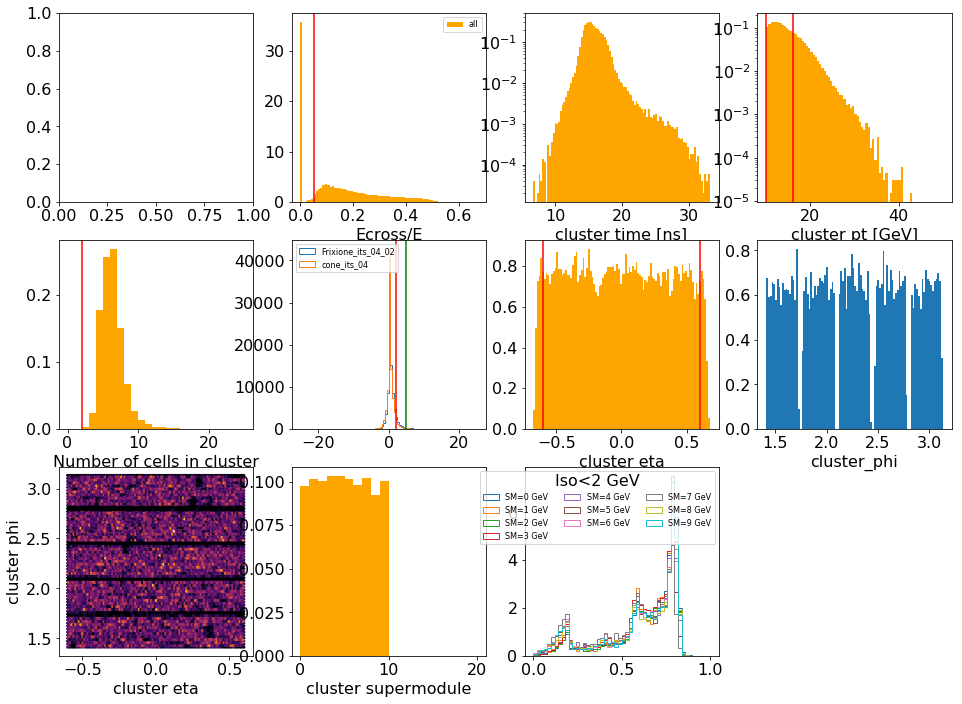

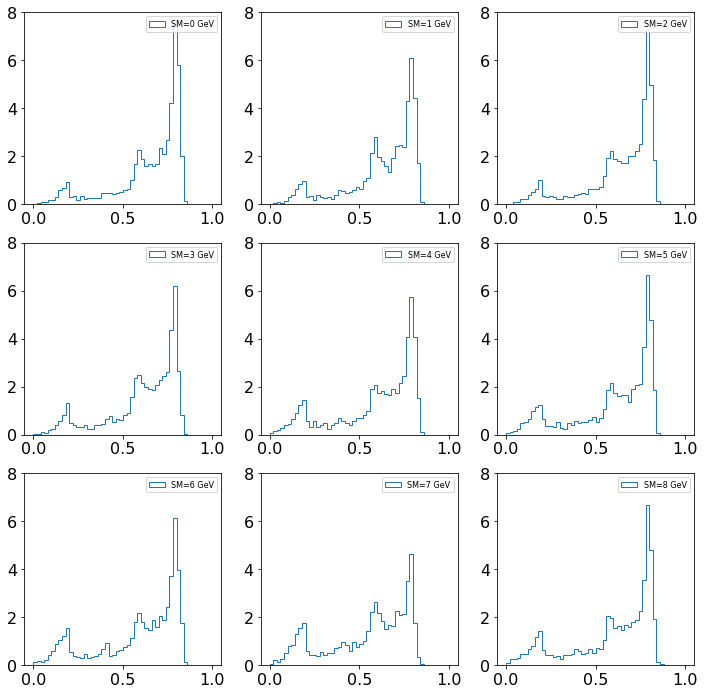

Processed 17g6a1_clusv1_1run_CrossTalk_small.root in 11.1357870102 seconds
All: 256313
ecross/e > 0.05 : 191198  (74.60  %)
pt >10.0  GeV : 134687  (70.44  %)
pt <16.0  GeV : 93858  (69.69  %)
ncell > 2: 93568  (99.69  %)
0<NN1<1.0 : 93568  (100.00  %)
0<NN2<1.0 : 93568  (100.00  %)
Local Maxima < 3 : 93106  (99.51  %)
|eta| < 0.6 : 85060  (91.36  %)
cluster_frixione_its_04_02 < 2 GeV: 77214  (90.78  %)


In [43]:
mcFiles = ['17g6a1_clusv1_1run_CrossTalk_small.root']
#mcFiles = ['17g6a1_clusv2_1run_CrossTalk_small.root']
#mcFiles = ['17g6a1_pthat2_clusterv2_small.root']

mcFullHists = getData(mcFiles)
print 'All:', mcFullHists.shape[0]
mcHists = applyCuts(mcFullHists)
plt.show()
#print 'After All cuts:', mcHists.shape[0]

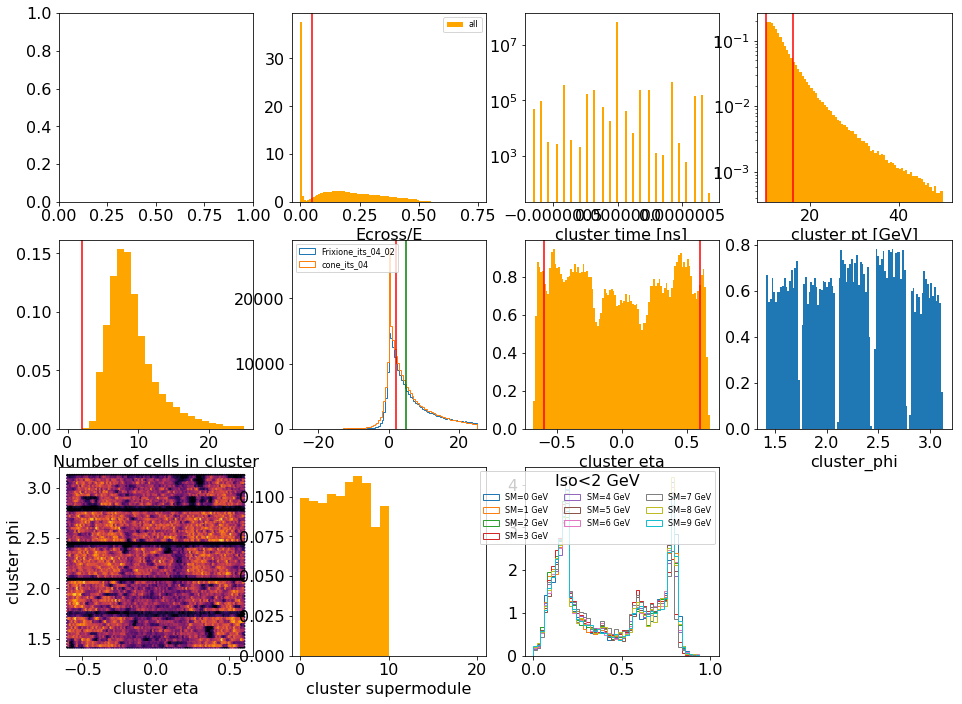

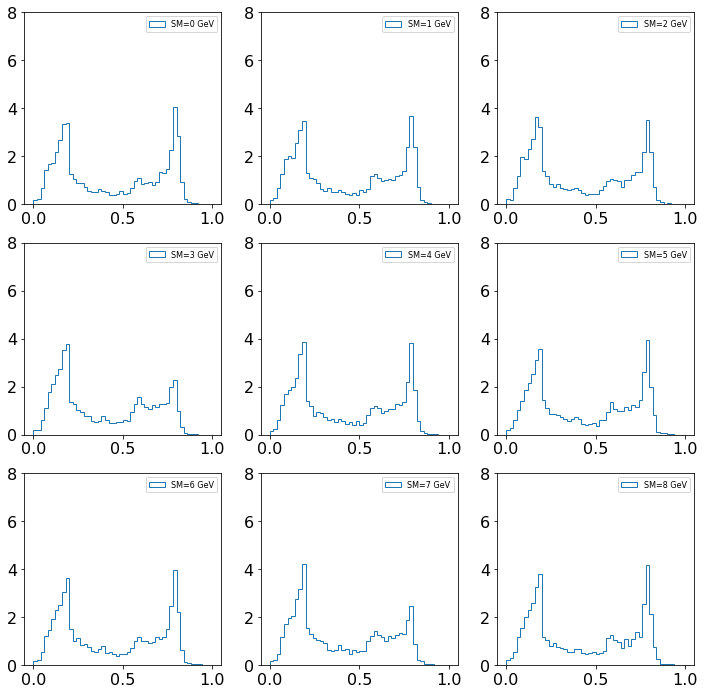

Processed 13def_clusv1_small.root in 40.3156030178 seconds
All: 2406248
ecross/e > 0.05 : 1665096  (69.20  %)
pt >10.0  GeV : 440757  (26.47  %)
pt <16.0  GeV : 328750  (74.59  %)
ncell > 2: 328397  (99.89  %)
0<NN1<1.0 : 328393  (100.00  %)
0<NN2<1.0 : 328391  (100.00  %)
Local Maxima < 3 : 271507  (82.68  %)
|eta| < 0.6 : 244235  (89.96  %)
cluster_frixione_its_04_02 < 2 GeV: 75121  (30.76  %)


In [42]:
dataFiles = ['13def_clusv1_small.root']
#['13def_clusv2_small.root']#['13def_clusv2_small.root']#['17q_CENT_wSDD_small.root']#['17q_FAST_small.root']#['13def_clusv2_small.root'] #['17q_FAST_small.root']#['13f_clusv1_small.root']#['13def_clusv1_small.root']#['13e_clusterv2_small.root']
dataFullHists = getData(dataFiles)
print 'All:',dataFullHists.shape[0]
dataHists = applyCuts(dataFullHists)
plt.show()


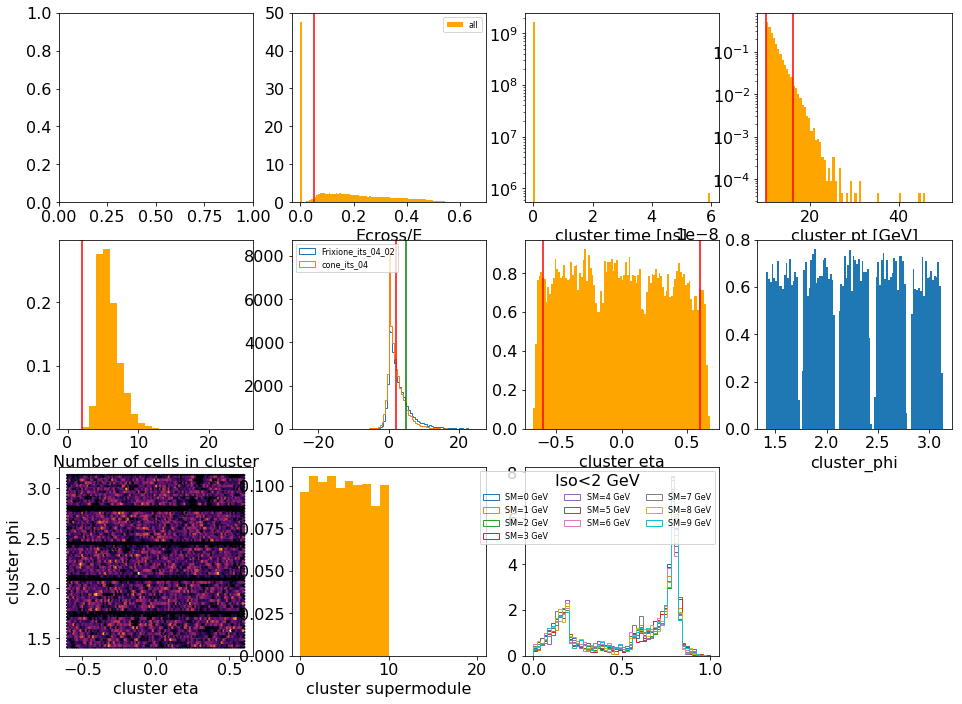

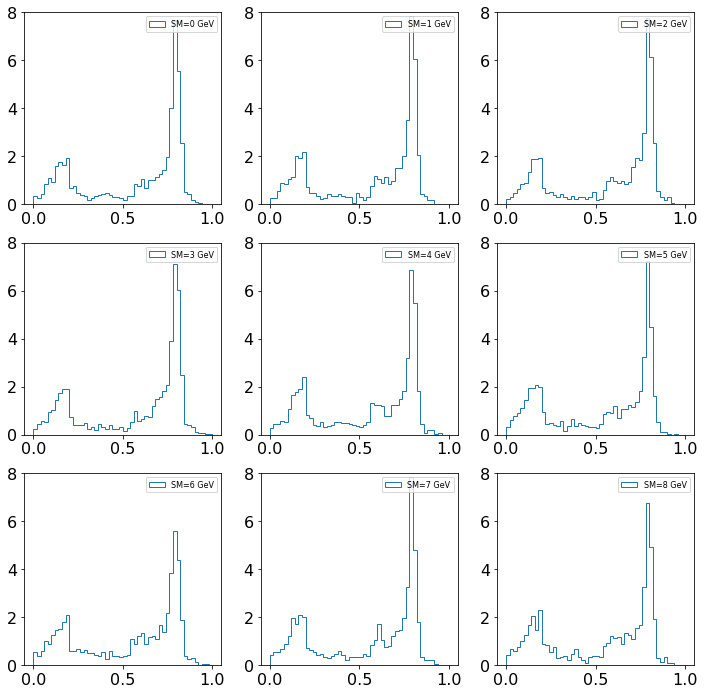

Processed 17g6a3_pthat2_clusterv2_small.root in 4.17255282402 seconds
ecross/e > 0.05 : 90444  (67.11  %)
pt >10.0  GeV : 43145  (47.70  %)
pt <16.0  GeV : 41608  (96.44  %)
ncell > 2: 41459  (99.64  %)
0<NN1<1.0 : 41459  (100.00  %)
0<NN2<1.0 : 41459  (100.00  %)
Local Maxima < 3 : 41459  (100.00  %)
|eta| < 0.6 : 38055  (91.79  %)
cluster_frixione_its_04_02 < 2 GeV: 20767  (54.57  %)
All: 134762
isolation < 2 GeV: 272557  (90.64  %)
Injected Signal: 272557


In [34]:
dataFiles = ['17g6a3_pthat2_clusterv2_small.root']
dataFullHists = getData(dataFiles)
dataHists = applyCuts(dataFullHists)
print 'All:',dataFullHists.shape[0]
InjectedSignal = applyCut(mcHists, 'cluster_frixione_its_04_02<2', 'isolation < 2 GeV:')
print 'Injected Signal:',InjectedSignal.shape[0]
#dataHists = pd.concat([dataHists ,InjectedSignal[:10000]])
plt.show()

In [ ]:
mcBKGFiles = ['17g6a3_pthat2_clusterv2_small.root']
mcBKGFullHists = getData(mcBKGFiles)
mcBKGHists = applyCuts(mcBKGFullHists)
plt.show()

## NN data

In [40]:
bins = 100
fitRange = (0.02, 0.88) #0.05 --0.90
xlabel = 'Deep Neural Network Output'
varname = 'cluster_NN1'
puritymin = 0.75
puritymax = 0.85
limit_yaxis = 6.1
fitRangeBKGonly=(0.03, 0.25)
Range=(0.0,1.0)



## lambda data

In [47]:
bins = 900
fitRange = (0.0, 1.0)
xlabel = 'Lambda [arb. units]'
varname = 'cluster_Lambda'
limit_yaxis = 13.0
puritymin = 0.0
puritymax = 0.27
fitRangeBKGonly=(0.3, 1.0)
Range=(0.0,2.0)



## B5x5 data

In [31]:
bins = 200
fitRange = (0.0, 2.0)
fitRangeBKGonly=(0.6, 1.0)

xlabel = 'B5x5 [mrad]'
varname = 'cluster_b5x5_lin'
puritymin = 0.0
#puritymax = 0.28
puritymax = 0.38
limit_yaxis = 6.6
Range=(0.0,1.5)





## Run template fit over different pt ranges

In [ ]:
isomax=2
nonisorange=(5,10)
isolation = 'cluster_frixione_its_04_02'
#isolation = 'cluster_iso_its_04'
tag = dataFiles[0].split('_small')[0]+mcFiles[0].split('_small')[0]+isolation

In [ ]:
#Set isolation variable and ranges: 
isomax=2.0
nonisorange=(5,10)
isolation = 'cluster_frixione_its_04_02'
#isolation = 'cluster_iso_its_04'
tag = dataFiles[0].split('_small')[0]+mcFiles[0].split('_small')[0]+isolation

#Set pt bins
#binedges = [10.0,11.0, 12.5, 16.0]#binedges = [10.0,16.0] #binedges = np.logspace(1.0, 1.176, num=5, base=10.0)
#binedges = [10,11.0,12.5,16.0]
binedges = [10.0,16.0]
PerSuperModule = True
nsupermodules = 10
SplitEta       = False
cutbadSM      = False

#bins =80 worked
for ipt in range(len(binedges)-1):
    bins = 80
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    title = '%2.1f < pT < %2.1f GeV'%(ptmin, ptmax)
    maskpt_do = dataHists.cluster_pt>ptmin
    maskpt_up = dataHists.cluster_pt<ptmax
    maskdata = maskpt_do & maskpt_up 

    mcmaskpt_do = mcHists.cluster_pt>ptmin
    mcmaskpt_up = mcHists.cluster_pt<ptmax  
    maskmc   = mcmaskpt_do & mcmaskpt_up
    
    
    
    Templates = getTemplates(dataHists[maskdata], mcHists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
    dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
    tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
    tf.plotFit(xlabel, title, True, puritymin, puritymax,
               normalize=False, figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso%2.0f_Noniso%2.0f_%2.0f.png'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))

     
        
    if(cutbadSM):
        dataveto = dataHists.cluster_SuperModule!=3
        dataveto2 = dataHists.cluster_SuperModule!=7
        #veto  = maskdataRemoved & dataHists.cluster_SuperModule!=7
        mcveto =  mcHists.cluster_SuperModule!=3
        mcveto2 =  mcHists.cluster_SuperModule!=7
        #maskmcRemoved = maskmcRemoved & mcHists.cluster_SuperModule!=7

        Templates = getTemplates(dataHists[maskdata & dataveto & dataveto2],
                                 mcHists[maskmc & mcveto & mcveto2], 
                                 bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
        tf.plotFit(xlabel, title, True, puritymin, puritymax,
                   normalize=False, figureFilename=varname+'NoSM3or7_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.png'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
    
    
    maskseta_data = [dataHists.cluster_eta>0, dataHists.cluster_eta<0]
    maskseta_mc   = [mcHists.cluster_eta>0, mcHists.cluster_eta<0]
   
    if SplitEta:
        for ieta in range(2):
            Templates = getTemplates(dataHists[maskdata & maskseta_data[ieta]], mcHists[maskmc & maskseta_mc[ieta]], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax,
                       figureFilename=varname+'Eta_%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.png'%(ieta,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
    
    
    if(PerSuperModule):
        purityarray = []
        purityarrayVeto = []
        
        farray = []
        farrayVeto = []
        fErrarray = []
        fErrarrayVeto = []
        
        chi2 = []
        chi2Veto = [] 
        bins = 200
        fig = plt.figure(figsize=(24,24))
        for ism in range(nsupermodules ):
            masksm = dataHists.cluster_SuperModule==ism
            plt.subplot(2,nsupermodules/2 ,ism+1)
            plt.hist2d(dataHists[maskdata & masksm].cluster_eta, dataHists[maskdata &masksm].cluster_phi,range=([-.70, .70], [-np.pi, np.pi]),bins=100)
        plt.show()
        #fig.tight_layout()
        fig.savefig('supermodules.png')
        for ism in range(nsupermodules):
            mask_supermodules_data = dataHists.cluster_SuperModule==ism
            mask_supermodules_mc   = mcHists.cluster_SuperModule==ism
            maskdata_sm = maskdata & mask_supermodules_data
            maskmc_sm  = maskmc & mask_supermodules_mc
        
            bins = 80 #was 80
            Templates = getTemplates(dataHists[maskdata_sm], mcHists[maskmc_sm], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax, ylimit=limit_yaxis,
                       figureFilename=varname+'SuperModule%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.png'%(ism,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
        
            #Everything EXCEPT the SM = ism
            purity, pmin, pmax = tf.getPurity(puritymin, puritymax)
            purityarray.append(purity)
            farray.append(tf.fitf)
            fErrarray.append(tf.fitferr)
            chi2.append(tf.chi2/tf.dof)
            
            bins = 100
            mask_supermodules_data = dataHists.cluster_SuperModule!=ism
            mask_supermodules_mc   = mcHists.cluster_SuperModule!=ism
            maskdata_sm = maskdata & mask_supermodules_data
            maskmc_sm  = maskmc & mask_supermodules_mc
            
            Templates = getTemplates(dataHists[maskdata_sm], mcHists[maskmc_sm], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax, ylimit=limit_yaxis,
                       figureFilename=varname+'VetoSuperModule%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.png'%(ism,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
            purity, pmin, pmax = tf.getPurity(puritymin, puritymax)
            purityarrayVeto.append(purity)
            farrayVeto.append(tf.fitf)
            fErrarrayVeto.append(tf.fitferr)
            chi2Veto.append(tf.chi2/tf.dof)

     
            
        fig = plt.figure(figsize=(12,5))
        plt.subplot(221)
        
        plt.plot(range(nsupermodules),purityarrayVeto, marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel('Purity')
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(purityarrayVeto),color='r',label='Average')
        plt.legend(loc='best')
        
        plt.subplot(222)
        plt.plot(range(nsupermodules),purityarray, marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel('Purity')
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(purityarray),color='r',label='Average =%2.1f'%(100.0*np.average(purityarray)))
        plt.axhspan(np.average(purityarray)-np.std(purityarray), 
                    np.average(purityarray)+np.std(purityarray),color='r',label='+/- RMS =%2.1f'%(100.0*np.std(purityarray)), alpha=0.4)
        plt.legend(loc='best')

        print 'PURITY RMS = ' , np.std(purityarray)
        
        plt.subplot(223)
        plt.plot(range(nsupermodules),chi2Veto, marker='o')
        plt.ylim([0.0,3.0])
        plt.ylabel('Chi2/dof')
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(chi2Veto),color='r',label='Average')

        plt.subplot(224)
        plt.plot(range(nsupermodules),chi2, marker='o')
        plt.ylim([0.0,3.0])
        plt.ylabel('Chi2/dof')
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(chi2),color='r',label='Average')
        
        
        plt.show()
        fig.savefig('SummaryPurity'+tag+'.png')
   


              
        fig = plt.figure(figsize=(12,5))
        plt.subplot(121)
        
        plt.errorbar(range(nsupermodules),farrayVeto, yerr=fErrarrayVeto,marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel('Fraction')
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(farrayVeto),color='r',label='Average')
       # plt.show()
        #fig.savefig('supermodulesVetoFraction.png')   

        plt.subplot(122)
        #fig = plt.figure(figsize=(12,12))
        plt.errorbar(range(nsupermodules),farray, yerr=fErrarray,marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel('Fraction')
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(farray),color='r',label='Average')
        plt.show()
        fig.savefig('SummaryFraction'+tag+'.png')


# Run on test data, including bkg only fit to bkg dominated region

FCN = 255.919784546 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 0.000132454766168 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,N,73937,1,0,0,,,FIXED
2,f,0.112544,0.00249231,0,0,,,


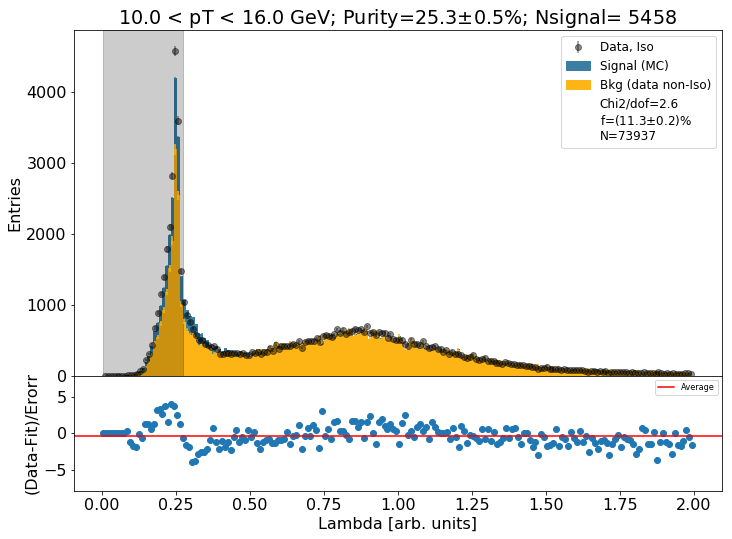

FCN = 82.4312210083 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 0.000149011611938 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,N,68910.5,723.223,0,0,,,
2,f,0,0.01,0,0,,,FIXED


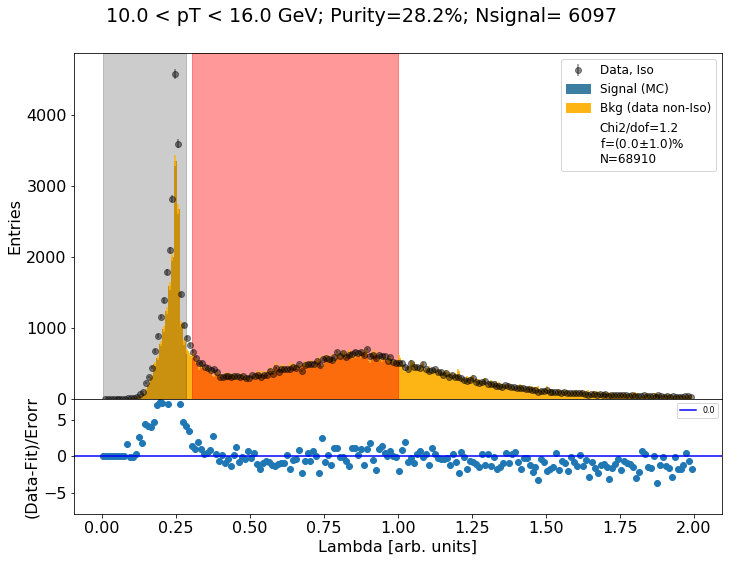

hello world
Purity = 0.25276, +0.00470, -0.00473
Purity = 0.25276, +0.00470, -0.00473
Purity = 0.00000, +0.02623, -0.02712
Purity = 0.00000, +0.02623, -0.02712


In [50]:
bins = 200 #75 was just perfect


print 'hello world'
nonisorange=(5,10)
isomax=2.0
isolation = 'cluster_frixione_its_04_02'

binedges = [10.0,16.0]

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    
    maskpt_do = dataHists.cluster_pt>ptmin
    maskpt_up = dataHists.cluster_pt<ptmax
    maskdata = maskpt_do & maskpt_up 

    mcmaskpt_do = mcHists.cluster_pt>ptmin
    mcmaskpt_up = mcHists.cluster_pt<ptmax  
    maskmc   = mcmaskpt_do & mcmaskpt_up
    
    title = '%2.1f < pT < %2.1f GeV'%(ptmin, ptmax)
    Templates = getTemplates(dataHists[maskdata], mcHists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, varRange=Range, isovar=isolation)
    dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
    #fit normally in the entire fit range
    fitRange=(0.0, 1.0)
    tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
    tf.plotFit(xlabel, title, True, puritymin, puritymax, normalize=False,figureFilename=xlabel+'pt_%2.2f_%2.2f.png'%(ptmin,ptmax))
    #fit with N float and f=0 fixed in bkg dominated region
    tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRangeBKGonly, fixN=False,fixf=True)
    tf.plotFit(xlabel, title, False, puritymin, puritymax, normalize=False,figureFilename=xlabel+'pt_%2.2f_%2.2f_BKGonlyfit.png'%(ptmin,ptmax))

    #tf.plotResiduals(varname,'residualBKGOnly.png')




##Checking isolation distribution and probabilities

In [ ]:
def GammaDistribution(x, k,theta):
    return np.power(x,k-1)*np.exp(-np.divide(x,theta))




data = dataHists.query('cluster_iso_its_04<0 and cluster_iso_its_04>-25')

fig = plt.figure(figsize=(12,4))
yhist, xhist, patches = plt.hist(data['cluster_iso_its_04'],bins=200,label='Data',histtype='step')
xhist= np.delete(xhist,-1)
xhist = np.add( xhist, (xhist[1]-xhist[0])/2.0 )
plt.show()
plt.plot(xhist,yhist)
plt.show()

print yhist, xhist
plt.show()

#FIT THE NEGATIVE TAIL OF THE DISTRIBUTION WITH A GAMMA FUNCTION
#def Chi2Gamma(N, k, theta):
#    model = N*GammaDistribution(xhist,k,theta)
#    return np.sum(np.power(np.divide(yhist-model, yhist), 2.0))
#
#mt = iminuit.Minuit(Chi2Gamma, N=np.sum(yhist), k =1, theta=1, error_k=0.1, error_theta=0.01,
#                        errordef=1)
#mt.migrad()


plt.plot(xhist, GammaDistribution(xhist,1.0,1.0))
plt.show()

## Isolation sideband

In [ ]:
test = dataHists.query('cluster_iso_its_04<200')
test = test.query('cluster_pt<16 and cluster_pt>10')
#test = test.query('cluster_iso_its_04_ue<1e10')
#test = test.query('cluster_iso_its_04_ue!=0.0000')


mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(test['cluster_iso_its_04_raw'],range=(-15,50),color='orange',bins=200,alpha=0.7,label='Raw')
plt.hist(test['cluster_iso_its_04'],range=(-25,50),bins=200,color='black',label='UE-subtracted',histtype='step')
plt.xlabel('Isolation Energy (track-only) [GeV]')
plt.legend(title='Data')

plt.subplot(1,3,2)
plt.hist(test['cluster_iso_its_04_raw'],range=(-15,50),color='orange',bins=200,alpha=0.7,label='Raw', cumulative=True, normed=True)
plt.hist(test['cluster_iso_its_04'],range=(-15,50),bins=200,color='black',label='UE-subtracted',histtype='step', normed = True, cumulative=True)
plt.xlabel('Isolation Energy (track-only) [GeV]')
#plt.legend(title='Data')

plt.subplot(1,3,3)
plt.hist(test['cluster_iso_its_04_ue'],range=(-15,50),bins=200,alpha=0.5, label='UE estimate')
plt.text(20, 5000, 'UE Average = %2.1f [GeV]'%(np.average(test['cluster_iso_its_04_ue'].dropna())), fontsize=12)
plt.xlabel('UE estimate (track-only) [GeV]')
#plt.legend(title='Data')
print ' Average UE', np.average(test['cluster_iso_its_04_ue'].dropna())

plt.show()

#isolation = 'cluster_frixione_its_04_02'

fig = plt.figure(figsize=(12,10))
test = mcHists.query('<200')
test = test.query('cluster_pt<16 and cluster_pt>10')
#test = test.query('cluster_iso_its_04_ue<1e10')
#test = test.query('cluster_iso_its_04_ue!=0.0000')

plt.subplot(2,2,3)
plt.hist(test['cluster_iso_its_04_raw'],range=(-25,50),color='orange',bins=200,alpha=0.7,label='Raw')
plt.hist(test['cluster_iso_its_04'],range=(-25,50),bins=200,color='black',label='UE-subtracted',histtype='step')
plt.xlabel('Isolation Energy (track-only) [GeV]')
plt.legend(title='MC Signal')
plt.subplot(2,2,4)
plt.hist(test['cluster_iso_its_04_ue'],range=(-25,50),bins=200,alpha=0.5, label='UE estimate')
plt.text(20, 5000, 'UE Average = %2.1f [GeV]'%(np.average(test['cluster_iso_its_04_ue'].dropna())), fontsize=12)

plt.xlabel('UE estimate (track-only) [GeV]')
plt.legend(title='MC Signal')
print ' Average UE', np.average(test['cluster_iso_its_04_ue'].dropna())



plt.show()

In [ ]:
test = dataHists.query('cluster_iso_its_04<200')
test = test.query('cluster_pt<16 and cluster_pt>10')


mpl.rcParams['legend.fontsize'] = 15

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(test['cluster_iso_its_04'],bins=40,range=(-15, 65),label='Data',normed=True,alpha=0.8,histtype='step',linewidth=2,color='black')
plt.xlabel('Isolation Energy [GeV]')
plt.axvspan(-2,2, color='green', alpha=0.6,label='Signal region')
plt.axvspan(5,10.0, color='blue', alpha=0.6,label='Sideband region')
plt.axvspan(4,15.0, color='orange', alpha=0.6,label='Extended sideband region')
plt.legend(loc='best')
plt.ylabel('Probability')
plt.yscale('log', nonposy='clip')
plt.subplot(1,2,2)
plt.hist(test['cluster_iso_its_04'],bins=100,range=(-15, 60),label='ola', cumulative=True, normed=True,alpha=0.8,histtype='step',linewidth=2,color='black')
plt.xlabel('Isolation Energy [GeV]')
plt.ylabel('Cumulative probability')
plt.axvspan(-2,2, color='green', alpha=0.6,label='Signal region')
plt.axvspan(4,15, color='orange', alpha=0.6,label='Extended sideband region')
plt.axvspan(5,7.5, color='red', alpha=0.8,label='Sideband region')

plt.show()
#fig.tight_layout()
fig.savefig('IsolationSideband.png')


#cluster_frixione_its_04_02

fig = plt.figure(figsize=(8,6))
plt.hist(test['cluster_frixione_its_04_02'],bins=160, range=(-15, 65), label='Data',normed=True,alpha=0.8,histtype='step',linewidth=2,color='black')
plt.xlabel('Isolation Energy (track-only) [GeV]')
plt.axvspan(-5,2.0, color='green', alpha=0.6,label='Signal region')
plt.axvspan(5,10, color='red', alpha=0.9,label='Sideband ')
plt.axvspan(4,15, color='orange', alpha=0.3,label='Extended sideband',hatch="/")
plt.legend(loc='best')
plt.ylabel('Probability')
plt.hist(test['cluster_frixione_its_04_02'],bins=160, range=(-15, 65), label='Data',normed=True,alpha=0.8,histtype='step',linewidth=2,color='black')

#plt.yscale('log', nonposy='clip')

plt.xlim([-15.0,+45.0])

plt.show()
#fig.tight_layout()
fig.savefig('IsolationSideband_limited.png')


plt.xlim([-20.0,+45.0])
plt.show()
fig.savefig('IsolationSideband_limited_zoom.png')



#test[test.cluster_frixione_its_04_02<2].hist(column='cluster_NN1',bins=40,label='ola',normed=True)
mpl.rcParams.update({'legend.fontsize': 8})
fig = plt.figure(figsize=(12,8))

limits =  [(4.0,5.0), (5.0, 7.5), (7.5,15.0)]
nrows = 2
ncolumns = 3
for lim in limits:
    plt.subplot(nrows,ncolumns,1)
    mask1 = test.cluster_iso_its_02>lim[0]
    mask2 = test.cluster_iso_its_02<lim[1]
    mask = mask1 & mask2
    tag = '%2.2f<Iso<%2.2f GeV'%(lim[0],lim[1])
    plt.hist(test[mask]['cluster_NN1'], linewidth=2.0,bins=20,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('cluster NN1 ')
    plt.subplot(nrows,ncolumns,2)
    plt.hist(test[mask]['cluster_b5x5_lin'],linewidth=2.0, bins=20,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('cluster b5x5 ')
    plt.legend(loc='best')

    plt.subplot(nrows,ncolumns,3)
    plt.hist(test[mask]['cluster_Lambda'],linewidth=2.0, bins=20,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('cluster lambda ')

    plt.subplot(nrows,ncolumns,4)
    plt.hist(test[mask]['cluster_ecross_over_e'],linewidth=2.0, range=(0,1), bins=10,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('Ecross/Ecluster')
    
    plt.subplot(nrows,ncolumns,5)
    plt.hist(test[mask]['cluster_pt'],linewidth=2.0, bins=5,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('cluster pt [GeV]')
    plt.subplot(nrows,ncolumns,6)
    plt.hist(test[mask]['cluster_ncell'],linewidth=2.0, range=(0,20), bins=20,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('Number of cells in cluster')

    #plt.subplot(nrows,4,7)
    #plt.hist(test[mask]['ncluster'],linewidth=2.0, range=(0,30), bins=30,label='Iso>%2.2f GeV'%(lowlim),normed=True,alpha=0.7,histtype='step')
    #plt.xlabel('#clusters in event')
    #plt.subplot(nrows,4,8)
    #plt.hist(test[mask]['ntrack'],linewidth=2.0,label='Iso>%2.2f GeV'%(lowlim), bins=100, range=(0,500), normed=True,alpha=0.7,histtype='step')
    #plt.xlabel('#tracks in event')
    #plt.subplot(3,4,9)
    #plt.hist(test[mask]['run_number'],linewidth=2.0,label='Iso>%2.2f GeV'%(lowlim),normed=True,alpha=0.7,histtype='step')
    #plt.xlabel('Run Number')
    #plt.subplot(3,4,10)
    #plt.hist(test[mask]['npileup_vertex_spd'],linewidth=2.0,label='Iso>%2.2f GeV'%(lowlim),normed=True,alpha=0.7,histtype='step')
    #plt.xlabel('npileup_vertex_spd')
    #plt.subplot(3,4,11)
    #plt.hist(test[mask]['pileup_vertex_spd_min_z_distance'],range=(0,50), bins=100, linewidth=2.0,label='Iso>%2.2f GeV'%(lowlim),normed=True,alpha=0.7,histtype='step')
    #plt.xlabel('pileup_vertex_spd_min_z_distance')
    #plt.yscale('log', nonposy='clip')
   
    
fig.savefig('IsolationCorrelation.png')

plt.show()


test = test.query('cluster_frixione_its_04_02>2')

print ' Correlation coefficients: '
print '%20s %2.2f'%('Iso and pt',test['cluster_frixione_its_04_02'].corr(test['cluster_pt']))
print '%20s %2.2f'%('Iso and NN1',test['cluster_frixione_its_04_02'].corr(test['cluster_NN1']))
print '%20s %2.2f'%('Iso and Lambda',test['cluster_frixione_its_04_02'].corr(test['cluster_Lambda']))
print '%20s %2.2f'%('Iso and b5x5',test['cluster_frixione_its_04_02'].corr(test['cluster_b5x5_lin']))
print '%20s %2.2f'%('Iso and Ecross/E',test['cluster_frixione_its_04_02'].corr(test['cluster_ecross_over_e']))
print '%20s %2.2f'%('Iso and Ncell',test['cluster_frixione_its_04_02'].corr(test['cluster_ncell']))


test = test.query('cluster_ncell<8')

print ' Correlation coefficients after applying a ncell<8 cut: '
print '%20s %2.2f'%('Iso and pt',test['cluster_frixione_its_04_02'].corr(test['cluster_pt']))
print '%20s %2.2f'%('Iso and NN1',test['cluster_frixione_its_04_02'].corr(test['cluster_NN1']))
print '%20s %2.2f'%('Iso and Lambda',test['cluster_frixione_its_04_02'].corr(test['cluster_Lambda']))
print '%20s %2.2f'%('Iso and b5x5',test['cluster_frixione_its_04_02'].corr(test['cluster_b5x5_lin']))
print '%20s %2.2f'%('Iso and Ecross/E',test['cluster_frixione_its_04_02'].corr(test['cluster_ecross_over_e']))
print '%20s %2.2f'%('Iso and Ncell',test['cluster_frixione_its_04_02'].corr(test['cluster_ncell']))


test = test.query('cluster_frixione_its_04_02<25')

print ' Correlation coefficients (after limiting isolation to below 25 GeV): '
print '%20s %2.2f'%('Iso and pt',test['cluster_frixione_its_04_02'].corr(test['cluster_pt']))
print '%20s %2.2f'%('Iso and NN1',test['cluster_frixione_its_04_02'].corr(test['cluster_NN1']))
print '%20s %2.2f'%('Iso and Lambda',test['cluster_frixione_its_04_02'].corr(test['cluster_Lambda']))
print '%20s %2.2f'%('Iso and b5x5',test['cluster_frixione_its_04_02'].corr(test['cluster_b5x5_lin']))
print '%20s %2.2f'%('Iso and Ecross/E',test['cluster_frixione_its_04_02'].corr(test['cluster_ecross_over_e']))
print '%20s %2.2f'%('Iso and Ncell',test['cluster_frixione_its_04_02'].corr(test['cluster_ncell']))


In [ ]:
print 'Correlation between Iso and pt %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_pt'])
print 'Correlation between Iso and NN1 %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_NN1'])
print 'Correlation between Iso and Lambda %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_Lambda'])
print 'Correlation between Iso and b5x5 %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_b5x5_lin'])
print 'Correlation between Iso and ncell %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_ncell'])



In [ ]:
calculateFitUncertainty(dataiso, signalmc, datanoniso, binEdges, puritymin, puritymax, fitRange)

In [ ]:
# vary data with poisson distribution in each bin
_ = getFitResults(varyWithinBins(dataiso, 10000), [signalmc], [datanoniso], binEdges,
                         pmin=puritymin, pmax=puritymax, verbosity=0, showDistributions=True)

In [ ]:
plotFitUncertaintyExamples(dataiso, dataisoerr, signalmc, datanoniso, binEdges)

In [ ]:
closureResults = checkClosureOverParameters(dataiso, signalmc, datanoniso, binEdges, 1000)

In [ ]:
plotCheckClosureResults(*closureResults)

# Check effect of binning

In [ ]:
def checkBinEffects(dataHists, mcHists, var, puritymin, puritymax, title, fitRange=None, varRange=(0.0, 1.0)):
    dataisos, dataisoerrs = [], []
    signalmcs, signalmcerrs = [], []
    datanonisos, datanonisoerrs = [], []
    binEdgess = []        
    bins, fracs, fracerrs, purs = [], [], [], []
    
    for nBins in range(20, 401,4):
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = getTemplates(dataHists, mcHists, nBins, var=var)
        
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
        bins.append(nBins)
        fracs.append(tf.fitf)
        fracerrs.append(tf.fitferr)
        purs.append(tf.getPurity(puritymin, puritymax)[0])
        
        if (nBins%10 == 0 and nBins <= 100):
            dataisos.append(dataiso)
            dataisoerrs.append(dataisoerr)
            signalmcs.append(signalmc)
            signalmcerrs.append(signalmcerr)
            datanonisos.append(datanoniso)
            datanonisoerrs.append(datanonisoerr)
            binEdgess.append(binEdges)
            
#     plt.figure(figsize=(18,18))
#     for i, (dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges) \
#     in enumerate(zip(dataisos, dataisoerrs, signalmcs, signalmcerrs, datanonisos, datanonisoerrs, binEdgess)):
#         plt.subplot(3,3,i+1)plt.figure(figsize=(18,18))
#         ax = plt.gca()
#         tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
#         tf.plotFit('', '', newFigure=False)
#         ax.legend_.remove()
#         ax.set_ylabel('')
#         ax.set_title('nBins: %i, frac: %2.2f, purity: %2.2f'%(len(binEdges)-1,
#                                                               tf.fitf, tf.getPurity(puritymin, puritymax)[0]))
#         ax.title.set_size(16)
#         ax.tick_params(labelsize=12)

    plt.figure(figsize=(12,12))
    plt.errorbar(bins, fracs, fracerrs, fmt='ko', label='Fit signal fraction')
    plt.plot(bins, purs, 'bd', label='Purity')
    plt.xlabel('Number of bins')
    plt.ylim([0.0, 1.0])
    plt.legend(loc='best', fontsize=12, numpoints=1)
    plt.title(title)
    ax = plt.gca()
    #ax.axhspan(np.mean(purs)-0.02, np.mean(purs)+0.02, color='green', alpha=0.2)
    
    plt.show()

In [ ]:
checkBinEffects(dataHists, mcHists, 'cluster_NN1', puritymin, puritymax, 'NN1', fitRange)

In [ ]:
checkBinEffects(dataHists, mcHists, 'cluster_Lambda', 0.0, 0.27, '$\lambda$', None, varRange=(0.0, 2.0))

In [ ]:
checkBinEffects(dataHists, mcHists, 'cluster_b5x5_lin', 0.0, 0.2, 'B5x5', None, varRange=(0.0, 2.0))

In [ ]:
#directory = 'v2-noue-old/'
directory = 'v1-ue-new/'

mcFile = directory + 'mcdata.csv'
dataFile = directory + 'data.csv'

mcdf = pd.read_csv(mcFile)
datadf = pd.read_csv(dataFile)

ptmin = 10
ptmax = 12

def applyCut(inputDataframe, cut, text=None):
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0]
    return cutDataframe

print 'Full MC events:', mcdf.shape[0]
mcHists = applyCut(mcdf, 'cluster_pt>%f and cluster_pt<%f'%(ptmin, ptmax), '%2.1f < pt < %2.1f GeV:'%(ptmin, ptmax))

print 'Full data events:', datadf.shape[0]
dataHists = applyCut(datadf, 'cluster_pt>%f and cluster_pt<%f'%(ptmin, ptmax), '%2.1f < pt < %2.1f GeV:'%(ptmin, ptmax))

In [ ]:
import random

random.sample(range(10), 10)